<a href="https://colab.research.google.com/github/araghavendra16/pytorchcv/blob/main/pytorch_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Import the packages needed.
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

PyTorch has a number of datasets available right from the library. Here we are using the well-known MNIST dataset of handwritten digits, available through torchvison.datasets.MNIST in PyTorch. The dataset object returns the data in the form of Python Imagine Library (PIL) images, which we convert to tensors by passing a transform=ToTensor() parameter.

When using your own notebooks, you can also experiment with the other built in datasets, in particular FashionMNIST.

In [3]:
from torchvision.transforms import ToTensor

data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
from google.colab import output
output.enable_custom_widget_manager()

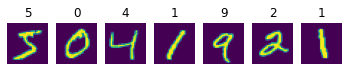

In [5]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

We have a total of 6000 training images and 1000 testing images. Its important to split out the data for training and testing. We also want to do some data exploration to get a better idea of what our data looks like

Each sample is a tuple in the following structure:

First element is the actual image of a digit, represented by a tensor of shape 1x28x28

Second element is a label that specifies which digit is represented by the tensor. It is a tensor that contains a number from 0 to 9.
data_train is a training dataset that we will use to train our model on. data_test is a smaller test dataset that we can use to verify our model.

In [6]:
print('Training samples:',len(data_train))
print('Test samples:',len(data_test))

print('Tensor size:',data_train[0][0].size())
print('First 10 digits are:', [data_train[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [7]:
print('Min intensity value: ',data_train[0][0].min().item())
print('Max intensity value: ',data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


Let's focus on the problem of handwritten digit recognition. It is a classification problem, because for each input image we need to specify the class - which digit it is.

In this unit, we start with the simplest possible approach for image classification - a fully-connected neural network (which is also called a perceptron). We will recap the way neural networks are defined in PyTorch, and how the training algorithm works. If you are familiar with those concepts - feel free to skip to the next unit, where we introduce Convolutional Neural Networks (CNNs).